In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from torch.utils.data import DataLoader
import os
import sys
import re
project_root = os.path.dirname(os.path.dirname(os.path.abspath('Pheno.ipynb')))
src_path = os.path.join(project_root, 'src')
sys.path.append(src_path)
%load_ext autoreload 
%autoreload 2

### Preprocess Liver Cancer datasets

In [1]:
def find_csv_filenames(path_to_dir, string_in_filename):
    filenames = os.listdir(path_to_dir)
    return [filename for filename in filenames if all([
        filename.endswith('.csv'),
        string_in_filename in filename
    ])]

# 示例用法
path = '../data/Liver'
string = 'cell_by_gene'
csv_files = sorted(find_csv_filenames(path, string))
print(csv_files)
metadata_files = sorted(find_csv_filenames(path, 'metadata'))
print(metadata_files)

NameError: name 'os' is not defined

In [8]:
exp_matrix = pd.read_csv(os.path.join(path, csv_files[i]), index_col=0)
exp_matrix

,ACTA2,ACTG2,ADAM12,ADAM28,ADGRE5,ADH1B,CCL21,AIM2,ANKRD55,AREG,...,Blank-51,Blank-52,Blank-53,Blank-54,Blank-55,Blank-56,Blank-57,Blank-58,Blank-59,Blank-60
cell,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,4.0,7.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,5.0,9.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131421,1.0,0.0,0.0,0.0,4.0,2.0,15.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131422,0.0,0.0,0.0,0.0,3.0,1.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
regex = re.compile(r'(\d+)_region_(\d+)')
# 读取数据
pseudo_bulk = {}
for i in range(len(csv_files)):
    exp_matrix = pd.read_csv(os.path.join(path, csv_files[i]), index_col=0)
    if i == 0:
       gene_features = exp_matrix.columns 
    exp_matrix = exp_matrix.loc[:, gene_features]
    print(exp_matrix.columns)
    metadata = pd.read_csv(os.path.join(path, metadata_files[i]), index_col=0)
    match = regex.search(csv_files[i])
    if match:
        adata_filename = f'{match.group(1)}_region_{match.group(2)}.h5ad'
        print(adata_filename)
    adata = anndata.AnnData(X=exp_matrix.values, obs=metadata)
    print(adata)
    pseudo_bulk[f'{match.group(1)}_{match.group(2)}'] = adata.X.sum(axis=0)
    adata.write_h5ad(os.path.join(path, adata_filename))

Index(['ACTA2', 'ACTG2', 'ADAM12', 'ADAM28', 'ADGRE5', 'ADH1B', 'CCL21',
       'AIM2', 'ANKRD55', 'AREG',
       ...
       'Blank-51', 'Blank-52', 'Blank-53', 'Blank-54', 'Blank-55', 'Blank-56',
       'Blank-57', 'Blank-58', 'Blank-59', 'Blank-60'],
      dtype='object', length=461)
1003_region_0.h5ad
AnnData object with n_obs × n_vars = 369399 × 461
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'barcodeCount'


/raid1/YiDingcheng/miniforge3/envs/pyg/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Index(['ACTA2', 'ACTG2', 'ADAM12', 'ADAM28', 'ADGRE5', 'ADH1B', 'CCL21',
       'AIM2', 'ANKRD55', 'AREG',
       ...
       'Blank-51', 'Blank-52', 'Blank-53', 'Blank-54', 'Blank-55', 'Blank-56',
       'Blank-57', 'Blank-58', 'Blank-59', 'Blank-60'],
      dtype='object', length=461)
1012_region_0.h5ad
AnnData object with n_obs × n_vars = 283525 × 461
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'barcodeCount'


/raid1/YiDingcheng/miniforge3/envs/pyg/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Index(['ACTA2', 'ACTG2', 'ADAM12', 'ADAM28', 'ADGRE5', 'ADH1B', 'CCL21',
       'AIM2', 'ANKRD55', 'AREG',
       ...
       'Blank-51', 'Blank-52', 'Blank-53', 'Blank-54', 'Blank-55', 'Blank-56',
       'Blank-57', 'Blank-58', 'Blank-59', 'Blank-60'],
      dtype='object', length=461)
1012_region_1.h5ad
AnnData object with n_obs × n_vars = 131426 × 461
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'barcodeCount'


/raid1/YiDingcheng/miniforge3/envs/pyg/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Index(['ACTA2', 'ACTG2', 'ADAM12', 'ADAM28', 'ADGRE5', 'ADH1B', 'CCL21',
       'AIM2', 'ANKRD55', 'AREG',
       ...
       'Blank-51', 'Blank-52', 'Blank-53', 'Blank-54', 'Blank-55', 'Blank-56',
       'Blank-57', 'Blank-58', 'Blank-59', 'Blank-60'],
      dtype='object', length=461)
1014_region_0.h5ad
AnnData object with n_obs × n_vars = 207552 × 461
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'barcodeCount'


/raid1/YiDingcheng/miniforge3/envs/pyg/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Index(['ACTA2', 'ACTG2', 'ADAM12', 'ADAM28', 'ADGRE5', 'ADH1B', 'CCL21',
       'AIM2', 'ANKRD55', 'AREG',
       ...
       'Blank-51', 'Blank-52', 'Blank-53', 'Blank-54', 'Blank-55', 'Blank-56',
       'Blank-57', 'Blank-58', 'Blank-59', 'Blank-60'],
      dtype='object', length=461)
1014_region_1.h5ad
AnnData object with n_obs × n_vars = 25449 × 461
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'barcodeCount'


/raid1/YiDingcheng/miniforge3/envs/pyg/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Index(['ACTA2', 'ACTG2', 'ADAM12', 'ADAM28', 'ADGRE5', 'ADH1B', 'CCL21',
       'AIM2', 'ANKRD55', 'AREG',
       ...
       'Blank-51', 'Blank-52', 'Blank-53', 'Blank-54', 'Blank-55', 'Blank-56',
       'Blank-57', 'Blank-58', 'Blank-59', 'Blank-60'],
      dtype='object', length=461)
1017_region_0.h5ad
AnnData object with n_obs × n_vars = 61404 × 461
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'barcodeCount'


/raid1/YiDingcheng/miniforge3/envs/pyg/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Index(['ACTA2', 'ACTG2', 'ADAM12', 'ADAM28', 'ADGRE5', 'ADH1B', 'CCL21',
       'AIM2', 'ANKRD55', 'AREG',
       ...
       'Blank-51', 'Blank-52', 'Blank-53', 'Blank-54', 'Blank-55', 'Blank-56',
       'Blank-57', 'Blank-58', 'Blank-59', 'Blank-60'],
      dtype='object', length=461)
1029_region_0.h5ad
AnnData object with n_obs × n_vars = 120434 × 461
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'barcodeCount'


/raid1/YiDingcheng/miniforge3/envs/pyg/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Index(['ACTA2', 'ACTG2', 'ADAM12', 'ADAM28', 'ADGRE5', 'ADH1B', 'CCL21',
       'AIM2', 'ANKRD55', 'AREG',
       ...
       'Blank-51', 'Blank-52', 'Blank-53', 'Blank-54', 'Blank-55', 'Blank-56',
       'Blank-57', 'Blank-58', 'Blank-59', 'Blank-60'],
      dtype='object', length=461)
122_region_0.h5ad
AnnData object with n_obs × n_vars = 91860 × 461
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'barcodeCount'


/raid1/YiDingcheng/miniforge3/envs/pyg/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Index(['ACTA2', 'ACTG2', 'ADAM12', 'ADAM28', 'ADGRE5', 'ADH1B', 'CCL21',
       'AIM2', 'ANKRD55', 'AREG',
       ...
       'Blank-51', 'Blank-52', 'Blank-53', 'Blank-54', 'Blank-55', 'Blank-56',
       'Blank-57', 'Blank-58', 'Blank-59', 'Blank-60'],
      dtype='object', length=461)
122_region_1.h5ad


/raid1/YiDingcheng/miniforge3/envs/pyg/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 151647 × 461
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'barcodeCount'
Index(['ACTA2', 'ACTG2', 'ADAM12', 'ADAM28', 'ADGRE5', 'ADH1B', 'CCL21',
       'AIM2', 'ANKRD55', 'AREG',
       ...
       'Blank-51', 'Blank-52', 'Blank-53', 'Blank-54', 'Blank-55', 'Blank-56',
       'Blank-57', 'Blank-58', 'Blank-59', 'Blank-60'],
      dtype='object', length=461)
63_region_0.h5ad
AnnData object with n_obs × n_vars = 228679 × 461
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'barcodeCount'


/raid1/YiDingcheng/miniforge3/envs/pyg/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
pseudo_bulk = pd.DataFrame(pseudo_bulk)
pseudo_bulk.index = exp_matrix.columns
pseudo_bulk

,1003_0,1012_0,1012_1,1014_0,1014_1,1017_0,1029_0,122_0,122_1,63_0
ACTA2,270227.0,434886.0,201380.0,59374.0,9884.0,32705.0,106966.0,38842.0,22886.0,13156.0
ACTG2,22833.0,17338.0,5980.0,3665.0,554.0,1138.0,5193.0,3040.0,3080.0,1697.0
ADAM12,16661.0,20374.0,3441.0,1697.0,399.0,3404.0,3379.0,5146.0,6441.0,2016.0
ADAM28,35283.0,13956.0,12717.0,1170.0,88.0,1554.0,3660.0,4583.0,3822.0,1905.0
ADGRE5,402208.0,346434.0,87069.0,41693.0,7982.0,42169.0,47220.0,60694.0,35784.0,29150.0
...,...,...,...,...,...,...,...,...,...,...
Blank-56,5819.0,2860.0,1556.0,388.0,52.0,214.0,555.0,520.0,652.0,279.0
Blank-57,5225.0,3626.0,1504.0,408.0,58.0,502.0,607.0,736.0,625.0,489.0
Blank-58,5817.0,2875.0,1964.0,427.0,54.0,253.0,797.0,1120.0,821.0,419.0
Blank-59,17939.0,7644.0,3699.0,888.0,75.0,538.0,1721.0,726.0,594.0,675.0


In [5]:
pseudo_bulk.to_csv(os.path.join(path, 'pseudo_bulk.csv'))

In [85]:
expression_data = pd.read_table('../data/TCGA/TCGA-COAD.htseq_counts.tsv')

In [75]:
clinical = pd.read_table('../data/TCGA/TCGA-LIHC.GDC_phenotype.tsv')
# clinical = pd.read_table('../data/TCGA/TCGA-COAD.GDC_phenotype.tsv')
clinical.columns

Index(['submitter_id.samples',
       'adjacent_hepatic_tissue_inflammation_extent_type',
       'age_at_initial_pathologic_diagnosis', 'albumin_result_lower_limit',
       'albumin_result_specified_value', 'albumin_result_upper_limit',
       'batch_number', 'bcr', 'bcr_followup_barcode', 'bcr_followup_uuid',
       ...
       'days_to_collection.samples', 'days_to_sample_procurement.samples',
       'initial_weight.samples', 'is_ffpe.samples', 'oct_embedded.samples',
       'preservation_method.samples', 'sample_type.samples',
       'sample_type_id.samples', 'state.samples', 'tissue_type.samples'],
      dtype='object', length=119)

In [76]:
# expression_data = pd.read_table('../data/Cleaned_data/Colon/TCGA-COAD.htseq_counts_clean.tsv', index_col=0)
expression_data = pd.read_csv('../data/Cleaned_data/Liver/TCGA-LIHC.htseq_counts_clean.csv', index_col=0)
# expression_data = pd.read_table('../data/TCGA/TCGA-LIHC_TPM_clean.tsv', index_col=0)
# label = pd.read_csv('../data/Cleaned_data/Colon/TCGA-COAD.survival_clean.csv')
label = pd.read_csv('../data/Cleaned_data/Liver/TCGA-LIHC.survival_clean.csv')

In [77]:
clinical['sample_id'] = clinical['submitter_id.samples'].str.replace('-', '.')
label = label.merge(clinical[['sample_id', 'batch_number', 'tumor_stage.diagnoses']], left_on='barcode', right_on='sample_id')
# label = label[label['sample_type'] == 'Tumor']
label
# label.to_csv('../data/Cleaned_data/Liver/TCGA-LIHC.survival_clean_tumor.csv')

,OS,X_PATIENT,OS.time,barcode,median_surv,sample_type,sample_id,batch_number,tumor_stage.diagnoses
0,0,TCGA-FV-A495,1,TCGA.FV.A495.01A,short,Tumor,TCGA.FV.A495.01A,275.62.0,stage ii
1,0,TCGA-ED-A7PZ,6,TCGA.ED.A7PZ.01A,short,Tumor,TCGA.ED.A7PZ.01A,345.53.0,stage ii
2,0,TCGA-ED-A97K,6,TCGA.ED.A97K.01A,short,Tumor,TCGA.ED.A97K.01A,399.48.0,stage iiia
3,0,TCGA-ED-A7PX,6,TCGA.ED.A7PX.01A,short,Tumor,TCGA.ED.A7PX.01A,365.54.0,stage ii
4,0,TCGA-BC-A3KF,8,TCGA.BC.A3KF.01A,short,Tumor,TCGA.BC.A3KF.01A,203.73.0,stage i
...,...,...,...,...,...,...,...,...,...
413,0,TCGA-DD-A4NP,3308,TCGA.DD.A4NP.01A,long,Tumor,TCGA.DD.A4NP.01A,303.59.0,stage i
414,0,TCGA-DD-A118,3437,TCGA.DD.A118.11A,long,Normal,TCGA.DD.A118.11A,100.78.0,stage ii
415,0,TCGA-DD-A118,3437,TCGA.DD.A118.01A,long,Tumor,TCGA.DD.A118.01A,100.78.0,stage ii
416,0,TCGA-DD-A73G,3478,TCGA.DD.A73G.01A,long,Tumor,TCGA.DD.A73G.01A,327.54.0,stage i


In [78]:
def convert_stage(x):
    if x['sample_type'] == 'Normal':
        return 0
    elif x['tumor_stage.diagnoses'] in ['not reported']:
        return pd.NA
    else:
        if 'stage iii' in x['tumor_stage.diagnoses'].lower():
            return 3
        elif 'stage ii' in x['tumor_stage.diagnoses'].lower():
            return 2
        elif 'stage iv' in x['tumor_stage.diagnoses'].lower():
            return 4
        elif 'stage i' in x['tumor_stage.diagnoses'].lower():
            return 1
        return pd.NA


label['tumor_stage_label'] = label.apply(convert_stage, axis=1)
label['early_stage'] = label['tumor_stage_label'] <= 2
label = label.dropna(subset=['tumor_stage_label'])
label = label.dropna(subset=['sample_type'])
label.value_counts(['early_stage', 'tumor_stage_label'])

early_stage  tumor_stage_label
True         1                    172
             2                     85
False        3                     83
True         0                     50
False        4                      4
Name: count, dtype: int64

In [6]:
expression_data = np.log1p(expression_data)

In [79]:
expression_data=expression_data.transpose()
expression_data.index = expression_data.index.str.replace('-', '.')
expression_data=expression_data[expression_data.index.isin(label['barcode'])]
expression_data

,ACTA2,ACTG2,ADAM12,ADAM28,ADGRE5,ADH1B,AIM2,ANKRD55,AREG,ASPN,...,VPS37B,VWF,WDFY4,XBP1,XCR1,YPEL5,ZBTB16,ZC3HAV1,ZFP36L1,ZNF331
TCGA.FV.A495.01A,6094,96,65,69,1726,21991,16,19,42,1500,...,622,3707,153,0,22,1774,623,777,6809,349
TCGA.ED.A7PZ.01A,8413,1476,55,11,4548,3495,3,10,218,345,...,675,3256,25,0,1,3286,13,858,2832,1024
TCGA.ED.A97K.01A,6415,109,239,5451,3765,27048,40,45,252,1551,...,2616,2556,294,0,13,6159,81,2871,15971,176
TCGA.ED.A7PX.01A,18077,1569,598,155,2888,540,13,10,50,2270,...,1682,3415,180,0,15,5204,23,1123,8968,430
TCGA.BC.A3KF.01A,4487,619,54,47,554,17776,1,36,7,201,...,621,3903,104,0,22,7001,427,2236,7918,1211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.DD.A4NP.01A,5408,314,11,23,643,423517,5,25,7,515,...,596,4764,85,0,7,5351,422,1788,9308,94
TCGA.DD.A118.11A,550,12,11,12,475,173907,24,72,5,299,...,376,192,73,0,15,2132,307,615,4990,432
TCGA.DD.A118.01A,10327,176,146,48,927,1466,7,3,23,1141,...,388,8270,160,0,13,7931,188,1081,6480,1327
TCGA.DD.A73G.01A,4369,464,13,26,1141,5949,3,23,7,418,...,723,9429,65,0,1,2410,29,694,3178,79


In [80]:
label.value_counts('early_stage')

early_stage
True     307
False     87
Name: count, dtype: int64

In [81]:
adata = sc.AnnData(expression_data)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=1000)
expression_data = expression_data[expression_data.columns[adata.var.highly_variable.values]]

/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


In [43]:
print(label['early_stage'])

227     True
54      True
21      True
396     True
62     False
       ...  
384     True
287     True
382     True
378     True
144     True
Name: early_stage, Length: 394, dtype: bool


In [59]:
np.random.seed(1123)
label['tumor_stage_label'] = label.iloc[np.random.permutation(len(label)), :]['tumor_stage_label'].values

In [82]:
from sklearn.model_selection import train_test_split
label['median_surv'] = label['OS.time'] < label['OS.time'].median()

train_exp, test_exp, train_label, test_label = train_test_split(expression_data, label, test_size=0.2, random_state=42, stratify=label['early_stage'])
train_exp.to_csv('../data/Cleaned_data/Liver/train_exp.csv')
test_exp.to_csv('../data/Cleaned_data/Liver/test_exp.csv')
train_label.to_csv('../data/Cleaned_data/Liver/train_label.csv')
test_label.to_csv('../data/Cleaned_data/Liver/test_label.csv')

In [68]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim import Adam
from model import BulkVAE
from dataset import TCGADataset, collate_fn
from trainer import VAETrainer
import lightning as pl
random_acc = []
for i in range(100):
    print(i)
    np.random.seed(i)
    label['tumor_stage_label'] = label.iloc[np.random.permutation(len(label)), :]['tumor_stage_label'].values
    train_exp, test_exp, train_label, test_label = train_test_split(expression_data, label, test_size=0.2, random_state=42, stratify=label['early_stage'])
    train_exp.to_csv('../data/Cleaned_data/Liver/train_exp.csv')
    test_exp.to_csv('../data/Cleaned_data/Liver/test_exp.csv')
    train_label.to_csv('../data/Cleaned_data/Liver/train_label.csv')
    test_label.to_csv('../data/Cleaned_data/Liver/test_label.csv')

    target_label = 'tumor_stage_label'
    train_dataset = TCGADataset('../data/Cleaned_data/Liver/train_exp.csv', '../data/Cleaned_data/Liver/train_label.csv', target_label)
    test_dateset = TCGADataset('../data/Cleaned_data/Liver/test_exp.csv', '../data/Cleaned_data/Liver/test_label.csv', target_label)
    # train_dataset = TCGADataset('data/Cleaned_data/Colon/train_exp.csv', 'data/Cleaned_data/Colon/train_label.csv', target_label)
    # test_dateset = TCGADataset('data/Cleaned_data/Colon/test_exp.csv', 'data/Cleaned_data/Colon/test_label.csv', target_label)

    print(len(train_dataset))
    print(len(test_dateset))
    n_input = 397
    n_hidden = 64
    n_latent = 32
    n_labels = 5
    n_batch = train_dataset.n_batch
    batch_size = 64
    n_epoch = 400

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dateset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # 定义模型
    model = BulkVAE(
        n_input=n_input,
        n_batch=n_batch,
        n_hidden=n_hidden,
        n_latent=n_latent,
        n_labels=n_labels,
        n_layers=2,
        dropout_rate=0.2,
    )
    optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    model=model.to('cuda')
    max_acc = 0
    for i in range(n_epoch):
        total_correct = 0
        for batch in train_loader:
            optimizer.zero_grad()
            data_batch, target_batch, batch_index, mean, variance = batch
            data_batch = data_batch.to('cuda')
            target_batch = target_batch.to('cuda')
            mean = mean.to('cuda')
            variance = variance.to('cuda')
            batch_index = batch_index.to('cuda')
            recon_loss, kl_z, kl_l, classification_loss, probs = model(data_batch, mean, variance, batch_index, target_batch)
            mean_recon_loss = torch.mean(recon_loss)
            mean_kl_z = torch.mean(kl_z)
            mean_kl_l = torch.mean(kl_l)
            # total_loss = classification_loss * 10
            if i < 200:
                total_loss = mean_recon_loss + mean_kl_z + mean_kl_l * 0.1
            else:
                total_loss = classification_loss * 50 + mean_recon_loss + mean_kl_z + mean_kl_l * 0.1
            total_loss.backward()
            optimizer.step()
            total_correct += torch.sum(torch.argmax(probs, dim=1) == target_batch)
        # print(f"Epoch: {i}, Loss: {total_loss}, Recon_loss: {mean_recon_loss}, KL_z: {mean_kl_z}, KL_l: {mean_kl_l}, Classification_loss: {classification_loss}")
        train_accu = total_correct
        total_correct = 0
        for batch in test_loader:
            data_batch, target_batch, batch_index, mean, variance = batch
            data_batch = data_batch.to('cuda')
            target_batch = target_batch.to('cuda')
            mean = mean.to('cuda')
            variance = variance.to('cuda')
            batch_index = batch_index.to('cuda')
            recon_loss, kl_z, kl_l, probs = model(data_batch, mean, variance, batch_index)
            prediction = torch.argmax(probs, dim=1)
            total_correct += torch.sum(prediction == target_batch)
        test_accu = total_correct
        if max_acc < total_correct/len(test_dateset):
            max_acc = total_correct/len(test_dateset)
    random_acc.append(max_acc)
    print(f'Random {i} max acc: {max_acc}')

0
315
79
Random 399 max acc: 0.4556962251663208
1
315
79
Random 399 max acc: 0.5696202516555786
2
315
79
Random 399 max acc: 0.4683544337749481
3
315
79
Random 399 max acc: 0.4556962251663208
4
315
79
Random 399 max acc: 0.4303797483444214
5
315
79
Random 399 max acc: 0.4556962251663208
6
315
79
Random 399 max acc: 0.49367091059684753
7
315
79
Random 399 max acc: 0.4303797483444214
8
315
79
Random 399 max acc: 0.41772153973579407
9
315
79
Random 399 max acc: 0.41772153973579407
10
315
79
Random 399 max acc: 0.4556962251663208
11
315
79
Random 399 max acc: 0.5316455960273743
12
315
79
Random 399 max acc: 0.5316455960273743
13
315
79
Random 399 max acc: 0.4683544337749481
14
315
79
Random 399 max acc: 0.41772153973579407
15
315
79
Random 399 max acc: 0.4683544337749481
16
315
79
Random 399 max acc: 0.40506330132484436
17
315
79
Random 399 max acc: 0.5063291192054749
18
315
79


KeyboardInterrupt: 

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
train_target = train_label['early_stage'].astype('category').cat.codes
test_target = test_label['early_stage'].astype('category').cat.codes
gbdt = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.03, max_depth=3, random_state=42)
gbdt.fit(train_exp, train_target)
pred = gbdt.predict(test_exp)

In [17]:
print(classification_report(test_target, pred))

              precision    recall  f1-score   support

           0       0.22      0.11      0.14        38
           1       0.56      0.75      0.64        57

    accuracy                           0.49        95
   macro avg       0.39      0.43      0.39        95
weighted avg       0.42      0.49      0.44        95



In [111]:
train_label.value_counts(['tumor_stage_label'])

tumor_stage_label
2                    137
3                    101
1                     61
4                     50
0                     31
Name: count, dtype: int64

In [55]:
from dataset import TCGADataset
target_label = 'sample_type'
train_set = TCGADataset('../data/Cleaned_data/Colon/train_exp.csv', '../data/Cleaned_data/Colon/train_label.csv', target_label)
test_set = TCGADataset('../data/Cleaned_data/Colon/test_exp.csv', '../data/Cleaned_data/Colon/test_label.csv', target_label)

In [3]:
label = pd.read_csv('../data/Cleaned_data/Liver/train_label.csv', index_col=0)

In [4]:
label['median_surv'].astype('category').cat.codes

TCGA.ZS.A9CF.01A    0
TCGA.G3.A25T.01A    1
TCGA.MI.A75C.01A    1
TCGA.UB.AA0V.01A    1
TCGA.DD.AAVR.01A    0
                   ..
TCGA.CC.A5UE.01A    1
TCGA.FV.A3R3.01A    1
TCGA.DD.AAEK.01A    1
TCGA.ZS.A9CF.02A    0
TCGA.CC.A3MC.01A    1
Length: 294, dtype: int8

In [56]:
def collate_fn(batch):
    data_batch, target_batch, batch_index = zip(*batch)

    batch_index = torch.tensor(batch_index, dtype=torch.float32).view(-1, 1)
    data_batch = torch.stack(data_batch, dim=0)
    target_batch = torch.stack(target_batch, dim=0)
    library_sizes = torch.sum(data_batch, dim=1)

    mean = torch.mean(library_sizes).expand(data_batch.size(0))
    variance = torch.var(library_sizes).expand(data_batch.size(0))

    return data_batch, target_batch, batch_index, mean, variance

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [114]:
for data, target, batch_index, mean, variance in train_loader:
    print(data, target, batch_index, mean, variance)
    break

tensor([[0.0000e+00, 0.0000e+00, 1.4350e+03,  ..., 8.1400e+02, 3.7800e+02,
         2.5300e+02],
        [0.0000e+00, 3.2000e+01, 3.4610e+03,  ..., 4.9700e+02, 1.1720e+03,
         6.6000e+02],
        [5.4000e+01, 4.1000e+01, 2.6228e+04,  ..., 1.8900e+02, 7.2680e+03,
         6.3440e+03],
        ...,
        [1.6000e+01, 5.0000e+00, 1.8170e+03,  ..., 6.0300e+02, 4.8900e+02,
         2.7300e+02],
        [6.0000e+00, 1.5000e+01, 9.0300e+02,  ..., 2.2200e+02, 2.0400e+02,
         1.9800e+02],
        [1.2000e+01, 1.5000e+01, 5.0490e+03,  ..., 2.4300e+03, 1.3650e+03,
         7.3200e+02]]) tensor([0, 3, 1, 2, 2, 4, 1, 1, 3, 3, 2, 3, 2, 3, 2, 2, 4, 1, 2, 3, 3, 2, 4, 2,
        2, 3, 3, 2, 2, 2, 3, 2]) tensor([[18.],
        [ 4.],
        [18.],
        [14.],
        [ 2.],
        [19.],
        [ 7.],
        [ 3.],
        [ 1.],
        [19.],
        [ 3.],
        [19.],
        [ 5.],
        [ 9.],
        [ 0.],
        [ 1.],
        [18.],
        [14.],
        [11.],
      

In [57]:
n_input = 398
n_hidden = 64
n_latent = 32
n_batch = len(train_set)
n_labels = 2
print(n_batch)

380


In [9]:
from model import BulkVAE

model = BulkVAE(n_input, n_batch, n_labels, n_hidden, n_latent)

optimizer = torch.optim.Adam(model.parameters(), lr=1)

for batch in train_loader:
    optimizer.zero_grad()
    data_batch, target_batch, batch_index, mean, variance = batch
    recon_loss, kl_z, kl_l, classification_loss, probs = model(data_batch, mean, variance, batch_index, target_batch)
    total_loss = torch.mean(recon_loss + kl_z + kl_l) + classification_loss
    total_loss.backward()
    optimizer.step()
    print(recon_loss, kl_z, kl_l, classification_loss, total_loss)
    break


tensor([10702743.0000,  4751273.0000, 25516744.0000, 12944392.0000,
        11689364.0000, 19038540.0000,  7409312.0000, 12891787.0000,
        16920158.0000, 25252558.0000,  4895038.0000, 24234324.0000,
         5555599.0000,  7734252.0000, 17018790.0000, 17231220.0000,
         6446980.0000, 20891880.0000, 11010207.0000,  7049693.0000,
        27267102.0000,  9580864.0000,  7624444.0000, 11348685.0000,
        12672920.0000, 16916026.0000,  6989196.5000, 12427053.0000,
        17487262.0000, 12102446.0000,  7138230.5000, 13046132.0000],
       grad_fn=<NegBackward0>) tensor([ 7.6726,  1.2526,  3.4310,  2.7497,  2.3621,  7.7888,  2.6538,  5.2459,
        19.8198,  1.9583,  5.8649, 13.8285,  1.5784,  4.6270,  0.6725,  6.5620,
         9.8480,  5.3109,  4.0237,  1.3213,  4.2406,  9.2825,  3.8794,  2.4801,
         9.8914, 15.9775,  2.1207,  0.8508,  6.8058,  4.2357,  0.3519,  5.2665],
       grad_fn=<SumBackward1>) tensor([863.2360, 863.2360, 863.2360, 859.4595, 835.7320, 839.1875, 863.

In [16]:
def _convert_mean_disp_to_counts_logits(mu, theta, eps=1e-6):
    r"""NB parameterizations conversion

        :param mu: mean of the NB distribution.
        :param theta: inverse overdispersion.
        :param eps: constant used for numerical log stability.
        :return: the number of failures until the experiment is stopped
            and the success probability.
    """
    assert (mu is None) == (
        theta is None
    ), "If using the mu/theta NB parameterization, both parameters must be specified"
    logits = (mu + eps).log() - (theta + eps).log()
    total_count = theta
    return total_count, logits

# Negative Binomail

In [24]:
from distribution import NegativeBinomial
from torch.distributions import NegativeBinomial as NB
tens = torch.Tensor([1000, 2000, 1310, 4203, 2310])
mu = torch.Tensor([1000])
theta = torch.Tensor([2000])
dist = NegativeBinomial(mu=mu, theta=theta)
total_count, logits = _convert_mean_disp_to_counts_logits(mu, theta)
print(total_count, logits)
dist_t = NB(total_count=total_count, logits=logits)
print(dist.log_prob(tens))
print(dist_t.log_prob(tens))


tensor([2000.]) tensor([-0.6931])
tensor([[   -4.5771,  -240.6323,   -33.0034, -1534.3276,  -377.5938]])
tensor([   -4.5776,  -240.6323,   -33.0029, -1534.3296,  -377.5938])


### TCGA Batch

In [70]:
from model import Classifier
n_input = 2000
n_hidden = 512
n_labels = 2
n_layers = 2
classifier = Classifier(n_input, n_hidden, n_labels, n_layers, dropout_rate=0.3)
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4, weight_decay=1e-3)
loss_fn = torch.nn.CrossEntropyLoss(weight=torch.Tensor([10, 1]))

In [71]:
import torch.nn.functional as F
train_acc = []
test_acc = []
for n in range(50):
    correct_num = 0
    for batch in train_loader:
        optimizer.zero_grad()
        data_batch, target_batch, batch_index, mean, variance = batch
        output = classifier(data_batch)
        loss = loss_fn(output, target_batch)
        loss.backward()
        optimizer.step()
        probs = F.softmax(output, dim=1)
        predictions = torch.argmax(probs, dim=1)
        correct_num += (predictions == target_batch).sum()
    print("Train Accuracy: ", correct_num.detach().numpy()/len(train_set))
    train_acc.append(correct_num.detach().numpy()/len(train_set))

    correct_num = 0
    for batch in test_loader:
        data_batch, target_batch, batch_index, mean, variance = batch
        output = classifier(data_batch)
        probs = F.softmax(output, dim=1)
        predictions = torch.argmax(probs, dim=1)
        correct_num += (predictions == target_batch).sum()
    print(predictions)
    print("Test Accuracy: ", correct_num.detach().numpy()/len(test_set))
    test_acc.append(correct_num.detach().numpy()/len(test_set))

Train Accuracy:  0.3105263157894737
tensor([0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 1, 1, 1, 0, 0])
Test Accuracy:  0.3263157894736842
Train Accuracy:  0.43157894736842106
tensor([1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 0])
Test Accuracy:  0.5263157894736842
Train Accuracy:  0.5657894736842105
tensor([1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
        1, 0, 0, 0, 0, 0, 1])
Test Accuracy:  0.5684210526315789
Train Accuracy:  0.65
tensor([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 1, 0])
Test Accuracy:  0.6105263157894737
Train Accuracy:  0.6736842105263158
tensor([0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
        0, 0, 1, 0, 1, 1, 1])
Test Accuracy:  0.6105263157894737
Train Accuracy:  0.7052631578947368
tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1

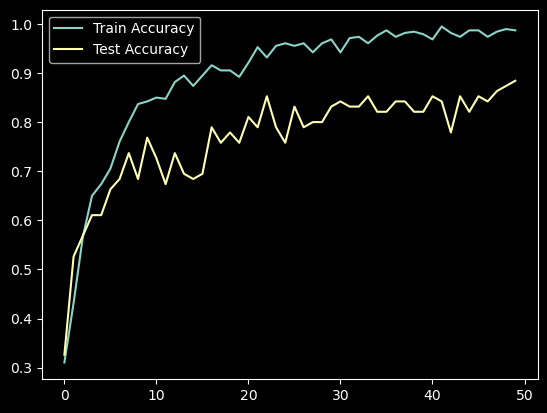

In [72]:
sns.lineplot(x=range(50), y=train_acc, label='Train Accuracy')
sns.lineplot(x=range(50), y=test_acc, label='Test Accuracy')
plt.show()